<a href="https://colab.research.google.com/github/dtabuena/Patch_Ephys/blob/main/Refactor/Analyze_Recs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
'Get Standard Modules'

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy import stats
import os
from scipy.signal import butter,filtfilt
from tqdm import tqdm
import warnings
from IPython.display import clear_output
from datetime import datetime
import sys
import warnings
import shutil
import urllib.request
import sklearn as skl
import sklearn.mixture as skl_mixture
import seaborn as sns
# warnings.filterwarnings('ignore')
# np.set_printoptions(threshold=sys.maxsize)
# clear_output(wait=False)


!pip install openpyxl
!pip install XlsxWriter

In [ ]:
import urllib
response = urllib.request.urlretrieve('https://raw.githubusercontent.com/dtabuena/Resources/main/Matplotlib_Config/Load_FS6.py','Load_FS6.py')
%run Load_FS6.py

In [ ]:
'''Get Repositories'''
"run dtabuena's ephys notebooks"
to_import = [
            'ABF_Quality_Control.ipynb',
            'Basic_Ephys.ipynb',
            'Simple_ABF_tools.ipynb',
            'fun_math.ipynb',
            'importing_abfs_from_dropbox.ipynb',
            'QC_recoding_dataframe.ipynb',
            'input_resistance_analyzer.ipynb',
            'gain_analyzer.ipynb',
            'latencey_analyzer.ipynb',
            'IV_analyzer.ipynb',
            'Vm_analyzer.ipynb',
            'membrane_analyzer.ipynb',
            'Ephys_wrapper.ipynb',
            'rheobase_analyzer.ipynb',
            ]
parent_folder = r'D:\Dropbox (Gladstone)\Gladstone Dropbox\Dennis Tabuena\0_Projects\_NPRS_Project'
os.chdir(parent_folder)

code_dir = 'git_code'
os.makedirs(code_dir,exist_ok=True)
os.chdir(code_dir)

for f in to_import:
    git_link = 'https://raw.githubusercontent.com/dtabuena/PClamp_Tools/main/'+f
    print(git_link)
    urllib.request.urlretrieve(git_link,f)
    %run $f


https://raw.githubusercontent.com/dtabuena/PClamp_Tools/main/ABF_Quality_Control.ipynb
https://raw.githubusercontent.com/dtabuena/PClamp_Tools/main/Basic_Ephys.ipynb
https://raw.githubusercontent.com/dtabuena/PClamp_Tools/main/Simple_ABF_tools.ipynb
https://raw.githubusercontent.com/dtabuena/PClamp_Tools/main/fun_math.ipynb
https://raw.githubusercontent.com/dtabuena/PClamp_Tools/main/importing_abfs_from_dropbox.ipynb
https://raw.githubusercontent.com/dtabuena/PClamp_Tools/main/QC_recoding_dataframe.ipynb
https://raw.githubusercontent.com/dtabuena/PClamp_Tools/main/input_resistance_analyzer.ipynb
https://raw.githubusercontent.com/dtabuena/PClamp_Tools/main/gain_analyzer.ipynb
https://raw.githubusercontent.com/dtabuena/PClamp_Tools/main/latencey_analyzer.ipynb
https://raw.githubusercontent.com/dtabuena/PClamp_Tools/main/IV_analyzer.ipynb
https://raw.githubusercontent.com/dtabuena/PClamp_Tools/main/Vm_analyzer.ipynb
https://raw.githubusercontent.com/dtabuena/PClamp_Tools/main/membrane_ana

In [ ]:
##### Setup Protocol List
VC_prot = ['VC - MemTest-10ms-160ms',
           'VC - Multi IV - 150ms',]
IC_prot = ['IC - Gain - D10pA',
           'IC - Gain - D20pA',
           'IC - Gain - D50pA',
           'IC - Rheobase',
           'IC - R input',
           'IC - Latentcy 800pA-1s'
           'VC - 3min GapFree',
           'I0 - 3min GapFree']


dataset = {'data_name': 'data',
           'data_source': r"D:\Dropbox (Gladstone)\Gladstone Dropbox\Dennis Tabuena\0_Projects\_NPRS_Project\Recs",
           'file_naming_scheme': ['Rec_date','Region','Slice_Num'],
           }


# my_order = ['E3KI_7-9mo_DGC', 'E4KI_7-9mo_DGC', 'fE4KIxSynCre_7-9mo_DGC',
#             'E3KI_17-20mo_DGC', 'E4KI_17-20mo_DGC', 'fE4KIxSynCre_17-20mo_DGC']



In [ ]:
analysis_dir =os.path.join(parent_folder,dataset['data_name'])
os.makedirs(analysis_dir,exist_ok=True)
os.chdir(analysis_dir)
print(os.getcwd())

D:\Dropbox (Gladstone)\Gladstone Dropbox\Dennis Tabuena\0_Projects\_NPRS_Project\data


In [ ]:
"""
New function to analyze using itterator.
BUT store results from each protocol in different dict
"""

In [ ]:
"""
Scripted Run
(unwraped 'ephys wrapper')
"""
# init Output
results = {}


'''Build Basic DF'''
abf_recordings_df, protocol_set = catalogue_recs(dataset['data_source'],dataset['file_naming_scheme'])
results['abf_recordings_df'] = abf_recordings_df
results['protocol_set'] = protocol_set

'''# Protocol Look Up Table'''
csv_name = cell_prot_lut(abf_recordings_df,protocol_set,csv_name=dataset['data_name']+'_Recording_LookUp')
results['prot_lut'] = csv_name



func_dict, arg_dict = init_func_arg_dicts()

'''Protocol Look Up Table'''
abf_recordings_df, problem_recs = analysis_iterator(abf_recordings_df,func_dict,arg_dict,verbose=False)
clear_output()
display(abf_recordings_df.head(3))
abf_recordings_df.to_csv('abf_recordings_df.csv')

'''Sort Cells'''
cell_df = cell_sorting(abf_recordings_df)
results['cell_df'] = cell_df
display(cell_df.head(3))
cell_df.to_csv('cell_df.csv')

,Recording_name,cell_id,Rec_date,Region,Slice_Num,protocol,abf_timestamp,channelList,Rmp_mV,Ra_10.0,...,rise_time_ms,fall_time_ms,dv_max,dv_min,Spike_latency_(ms),Ramp_AP_thresh,Ramp_Vh,Ramp_Rheobase,Input_Resistance_MO,Rin_Rsqr
file_name,,,,,,,,,,,,,,,,,,,,,
D:\Dropbox (Gladstone)\Gladstone Dropbox\Dennis Tabuena\0_Projects\_NPRS_Project\Recs\2025x03x13_PreOA_S1_0000.abf,2025x03x13_PreOA_S1_0000.abf,2025x03x13_PreOA_S1,2025x03x13,PreOA,S1,I0 - GapFree - LFP,2025-03-13T11:57:37.185,"[0, 1]",None,None,...,None,None,None,None,None,None,None,None,None,None
D:\Dropbox (Gladstone)\Gladstone Dropbox\Dennis Tabuena\0_Projects\_NPRS_Project\Recs\2025x03x13_PreOA_S1_0001.abf,2025x03x13_PreOA_S1_0001.abf,2025x03x13_PreOA_S1,2025x03x13,PreOA,S1,I0 - GapFree - LFP,2025-03-13T11:58:20.250,"[0, 1]",None,None,...,None,None,None,None,None,None,None,None,None,None
D:\Dropbox (Gladstone)\Gladstone Dropbox\Dennis Tabuena\0_Projects\_NPRS_Project\Recs\2025x03x13_PreOA_S1_0002.abf,2025x03x13_PreOA_S1_0002.abf,2025x03x13_PreOA_S1,2025x03x13,PreOA,S1,I0 - GapFree - LFP,2025-03-13T12:01:20.887,"[0, 1]",None,None,...,None,None,None,None,None,None,None,None,None,None


,Recording_name,Rec_date,Region,Slice_Num,protocol,abf_timestamp,channelList,Rmp_mV,Ra_10.0,Rm_10.0,...,rise_time_ms,fall_time_ms,dv_max,dv_min,Spike_latency_(ms),Ramp_AP_thresh,Ramp_Vh,Ramp_Rheobase,Input_Resistance_MO,Rin_Rsqr
2025x03x13_PreOA_S1,"[2025x03x13_PreOA_S1_0000.abf, 2025x03x13_PreO...","[2025x03x13, 2025x03x13, 2025x03x13]","[PreOA, PreOA, PreOA]","[S1, S1, S1]","[I0 - GapFree - LFP, I0 - GapFree - LFP, I0 - ...","[2025-03-13T11:57:37.185, 2025-03-13T11:58:20....","[[0, 1], [0, 1], [0, 1]]","[None, None, None]","[None, None, None]","[None, None, None]",...,"[None, None, None]","[None, None, None]","[None, None, None]","[None, None, None]","[None, None, None]","[None, None, None]","[None, None, None]","[None, None, None]","[None, None, None]","[None, None, None]"
2025x03x13_PreOA_S2,"[2025x03x13_PreOA_S2_0000.abf, 2025x03x13_PreO...","[2025x03x13, 2025x03x13, 2025x03x13, 2025x03x1...","[PreOA, PreOA, PreOA, PreOA, PreOA, PreOA, Pre...","[S2, S2, S2, S2, S2, S2, S2, S2, S2, S2, S2, S...","[I0 - 3min GapFree, VC - MemTest-10ms-160ms, I...","[2025-03-13T16:19:53.186, 2025-03-13T16:21:33....","[[0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1...","[5.0150814, None, -48.30315, None, None, None,...","[None, 19.74832338433999, None, None, None, No...","[None, 717.3841810086092, None, None, None, No...",...,"[None, None, None, None, None, None, 0.275, No...","[None, None, None, None, None, None, 0.45, Non...","[None, None, None, None, None, None, 184.75705...","[None, None, None, None, None, None, -101.8008...","[None, None, None, None, None, None, None, 58....","[None, None, None, None, None, None, None, -37...","[None, None, None, None, None, None, None, -70...","[None, None, None, None, None, None, None, 47....","[None, None, None, None, None, None, None, Non...","[None, None, None, None, None, None, None, Non..."


C:\Users\denni\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\denni\anaconda3\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\denni\AppData\Local\Temp\ipykernel_3220\1718039341.py:2: RuntimeWarning: invalid value encountered in divide
  isi_ratio = (spike_counts/isi_rates)


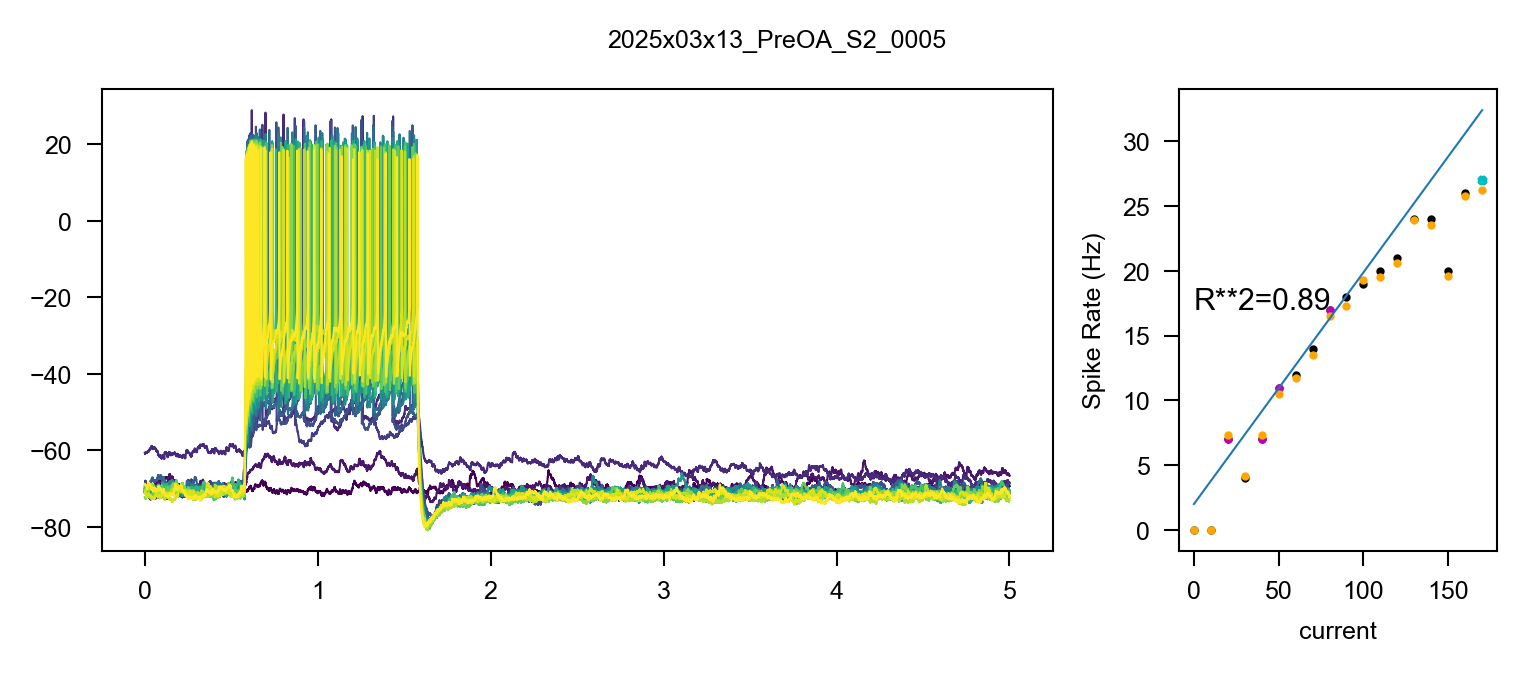

C:\Users\denni\AppData\Local\Temp\ipykernel_3220\3615807742.py:30: RuntimeWarning: invalid value encountered in divide
  sweep_adaption = [ 1-np.divide(spike_rates[si],mean_inst_rates[si])  for si in range(len(spike_times))]


{'sAHP': 6.7261963,
 'ADR': 0.4486670448099836,
 'Gain_(HzpA)': 0.17866666666666667,
 'Gain_R2': 0.8933333333333332,
 'Stim_Levels_(pA)': array([  0.,  10.,  20., ..., 150., 160., 170.]),
 'Spike_Counts': array([ 0,  0,  7, ..., 20, 26, 27]),
 'Firing_Duration_%': array(0.0016),
 'Gain_Vh': array([-69.8832, -68.6913, -64.3276, ..., -72.2348, -71.8986, -72.0901],
       dtype=float32),
 'V_stim': [-70.373535,
  -63.87329,
  -49.102783,
  -52.368164,
  -51.086426,
  -47.302246,
  -45.440674,
  -43.73169,
  -41.71753,
  -39.79492,
  -39.3219,
  -36.865234,
  -36.712646,
  -35.095215,
  -33.90503,
  -32.043457,
  -32.043457,
  -30.50232],
 'max_adapt%': 0.015544041450777257,
 'adapt_thresh_90': 100.0,
 'inact_current_pA': 170.1}

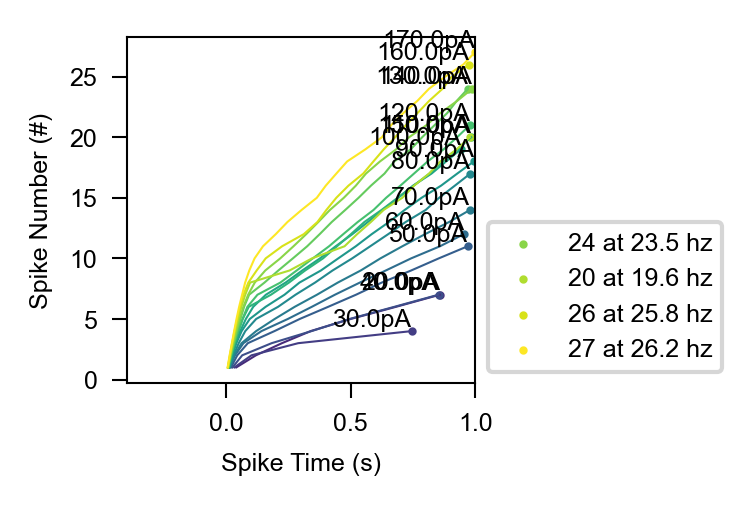

In [ ]:
# abf = abf_or_name(r'D:\Dropbox (Gladstone)\Gladstone Dropbox\Dennis Tabuena\0_Projects\_NPRS_Project\Recs\2025x03x13_PreOA_S2_0005.abf')
# spike_args_gain={'spike_thresh':10, 'high_dv_thresh': 20,'low_dv_thresh': -5,'window_ms': 3}
# gain_analyzer(abf,spike_args_gain, 1, 4, .7,[-60,-80])

# gain_analyzer

In [ ]:

# fast_results = ephys_wrapper_local(dataset,VC_prot,IC_prot,strat_cols=['Genotype','Age_Bin'],age_bin_dict=age_bin_dict)

In [ ]:
print(os.getcwd().replace('\\','/'))

C:/Users/dennis.tabuena/Dropbox (Gladstone)/0_Projects/_ApoE Patch Seq/Analysis_Workspace/Ephys/patch_seq_Cohort_02


In [ ]:
# fast_results = substitute_gain_rheobase(fast_results,
#                                        strat_cols=['Genotype','Age_Bin','Cell_Type'],
#                                        age_bin_dict=age_bin_dict)


In [ ]:
f = fast_results

In [ ]:
import pickle

# File path for pickling
pickle_file = 'cohort_2_results_data_dict.pkl'
# Pickling the complex dictionary
with open(pickle_file, 'wb') as file:
    pickle.dump(fast_results, file)

# Loading the pickle file to verify
with open(pickle_file, 'rb') as file:
    fast_results = pickle.load(file)

print("Loaded Dictionary:", fast_results)

Loaded Dictionary: {'abf_recordings_df':                                                                                        Recording_name  \
file_name                                                                                               
C:/Users/dennis.tabuena/Dropbox (Gladstone)/0_P...  2024x04x24_E3KI_F_P598_sagi_s001_c001_DGC_0000...   
C:/Users/dennis.tabuena/Dropbox (Gladstone)/0_P...  2024x04x24_E3KI_F_P598_sagi_s001_c001_DGC_0001...   
C:/Users/dennis.tabuena/Dropbox (Gladstone)/0_P...  2024x04x24_E3KI_F_P598_sagi_s001_c001_DGC_0003...   
C:/Users/dennis.tabuena/Dropbox (Gladstone)/0_P...  2024x04x24_E3KI_F_P598_sagi_s001_c001_DGC_0004...   
C:/Users/dennis.tabuena/Dropbox (Gladstone)/0_P...  2024x04x24_E3KI_F_P598_sagi_s001_c001_DGC_0005...   
...                                                                                               ...   
C:/Users/dennis.tabuena/Dropbox (Gladstone)/0_P...  2024x11x08_E3KI_F_P295_sagi_s001_c002_DGC_0006...   
C:/Users/denni

In [ ]:

single_val_strat_groups = ['ap_amplitutude',
                            'Rmp_mV',
                            'Cmq_160.0',
                            'Ra_160.0',
                            'Rm_160.0',
                            'Gain_(HzpA)',
                            'inact_current_pA',
                            'Rheobase',
                            'AP_thresh_US',
                            'fast_after_hyperpol',
                            'Spike_latency_(ms)',
                            'Input_Resistance_MO',
                            ]


manual_exclusions = ['']
exclusion_overide = ['']
file_naming_scheme = dataset['file_naming_scheme']
strat_df_dict = fast_results['strat_df_dict'].copy()
strat_df_dict = {k:strat_df_dict[k] for k in my_order}
filtered_dict, fail_dict = final_qc(strat_df_dict,file_naming_scheme,qc_Rmp=-35,qc_AP_amp=20,qc_RR=.20,qc_Ra=np.inf,manual_exclusions=manual_exclusions,exclusion_overide=exclusion_overide)
alt_strat_dict = restratify_results(filtered_dict,file_naming_scheme,single_val_strat_groups)

resp_curve_list = ['IV_Early_(V_stim)','IV_Early_(I_peak)','IV_Steady_State_(I_mean)','Stim_Levels_(pA)','Spike_Counts']
response_curve_data = stratify_response_curve(filtered_dict,resp_curve_list,strat_list=[''])
alt_strat_dict.update(response_curve_data)
write_strat_dfs_local(alt_strat_dict, dataset['data_name']+'_results_stratified_alternate')
print(os.getcwd())


2024x05x06_E3KI_F_P254_sagi_s003_c006_DGC Fail - Rmp = -25.007247924804688 mV > -35 mV
2024x05x08_E3KI_F_P256_sagi_s003_c009_DGC Fail - RR = 0.2837684461068159 > 0.2
2024x05x29_E3KI_F_P264_sagi_s001_c001_DGC Fail - RR = 0.26199702724494767 > 0.2
2024x07x07_E4KI_F_P269_sagi_s003_c007_DGC Fail - RR = 0.2527165964887587 > 0.2
2024x07x07_E4KI_F_P269_sagi_s003_c008_DGC Fail - RR = 0.20987976468142172 > 0.2
2024x09x23_fE4KIxSynCre_F_P263_sagi_s001_c001_DGC Fail - RR = 0.6918317844706429 > 0.2
2024x09x24_fE4KIxSynCre_F_P264_sagi_s002_c003_DGC Fail - RR = 0.22923951016311464 > 0.2
2024x09x26_fE4KIxSynCre_F_P262_sagi_s001_c001_DGC Fail - RR = 0.3651399705692814 > 0.2
2024x10x01_fE4KIxSynCre_F_P267_sagi_s001_c001_DGC Fail - RR = 0.24165597358972155 > 0.2
2024x04x24_E3KI_F_P598_sagi_s001_c001_DGC Fail - Rmp = -31.582923889160156 mV > -35 mV
2024x04x25_E3KI_F_P590_sagi_s001_c003_DGC Fail - RR = 0.3121144719203898 > 0.2
2024x04x26_E3KI_F_P591_sagi_s001_c002_DGC Fail - RR = 0.24974461768473533 > 0.2

In [ ]:
feature_list = ['Cm_pc_10.0',
             'Cmq_160.0',
             'Input_Resistance_MO',
             'Rm_160.0',
             'Rmp_mV',
             'Gain_(HzpA)',
             'Spike_latency_(ms)',
             'Rheobase',
             'inact_current_pA',
             'ap_amplitutude',
             'fast_after_hyperpol',
             'sAHP',
             'AP_thresh_US',
             'ap50_width_ms']



In [ ]:
# label_dict = {'E3KI_7-9mo':'Young E3',
#             'E4KI_7-9mo':'Young E4',
#             'fE4KIxSynCre_7-9mo':'Young EKO',
#             'E3KI_17-20mo':'Aged E3',
#             'E4KI_17-20mo':'Aged E4',
#             'fE4KIxSynCre_17-20mo':'Aged EKO',}



In [ ]:
# def plot_violins(data_df,plot_list,colors=None,title=None,stats_dict=None):
#     my_order = list(label_dict.keys())
#     if colors is None:
#         colors = [(0.0, 0.0, 1.0),   # Blue
#                  (1.0, 0.0, 0.0),   # Red
#                  (1.0, 0.5, 0.0),   # Org?
#                  (0.3, 0.3, 1.0),   # Blue
#                  (1.0, 0.3, 0.3),   # Red
#                  (1.0, 0.6, 0.3),   # Org
#                  ]
#         colors = sns.color_palette(custom_colors)
#         color_map = dict(zip(my_order, colors))
#         fig_list = []
#         for metric in plot_list:
#             fig,ax = plt.subplots(1,1,figsize=(2,1))
#             fig_list.append(fig)
#             # Create the violin plot
#             sns.violinplot(x='Strat_ID', y=metric, data=data_df, width=0.7, ax=ax,
#                         hue='Strat_ID', palette=color_map,order=my_order,  inner="quartile", linewidth=.2)
#             violins = [v for v in ax.collections if isinstance(v, matplotlib.collections.PolyCollection)]  # Get all violins order=my_order,
#             for i, violin in enumerate(violins):
#                 violin.set_facecolor([0.9, 0.9, 0.9])  # Set the fill color to light gray
#                 violin.set_edgecolor(colors[i % len(colors)])  # Set edge color using colors_sns
#                 violin.set_linewidth(1)  # Set the linewidth to make the edges more visible

#             # Create the scatter plot on the same axes
#             sns.stripplot(x='Strat_ID', y=metric, data=data_df, ax=ax,
#                         color='black',  order=my_order, size=1, jitter=True)
#             current_labels = [tick.get_text() for tick in ax.get_xticklabels()]
#             new_labels = [label_dict[label] if label in label_dict else label for label in current_labels]
#             tick_positions = ax.get_xticks()
#             ax.set_xticks(tick_positions)
#             ax.set_xticklabels(current_labels, rotation=45, ha='right')
#             ax.set_xlabel(None)
#             if title is not None:
#                 ax.set_title(title)

#             if stats_dict is not None:
#                 stats_df = stats_dict[metric]
#                 stats_df['']

#             plt.show()


#         return fig_list
# type_1_fig_list = plot_violins(concat_t1_df,feature_list,label_dict,title='Type I')
# type_2_fig_list = plot_violins(concat_t2_df,feature_list,label_dict,title='Type II')

In [ ]:
def generate_prism_csv(data_df,max_replicates=None):
    data_type = data_df.columns[0]

    # Step 1: Group data by 'Age_Bin' and 'Genotype' and collect values
    grouped = data_df.groupby(['Age_Bin', 'Genotype'])[data_type].apply(list).reset_index()

    # Step 2: Determine maximum number of replicates based on the size of groups
    if max_replicates is None:
        max_replicates = grouped[data_type].str.len().max()

    # Step 3: Prepare a DataFrame for the multi-level index
    results = []

    # Replicate numbering function (retained as per your request)
    def rep_num(i):
        if i == 0:
            return ""
        else:
            return f'{i + 1:03}'  # Returns '001', '002', etc.

    # Step 4: Generate all possible rows, padding with None where necessary
    for _, row in grouped.iterrows():
        age_bin = row['Age_Bin']
        geno_type = row['Genotype']
        values = row[data_type]

        # Ensure every group has max_replicates, padding missing values with None
        for i in range(max_replicates):
            if i < len(values):
                # If value exists, use it
                results.append({'Age_Bin': age_bin, 'Genotype': geno_type, 'Replicate': rep_num(i), 'Value': values[i]})
            else:
                # If no value, add a row with None
                results.append({'Age_Bin': age_bin, 'Genotype': geno_type, 'Replicate': rep_num(i), 'Value': None})

    # Step 5: Create a DataFrame from the results
    final_df = pd.DataFrame(results)

    # Step 6: Pivot the DataFrame to have Age_Bin as index and multi-level columns, ensuring all replicates exist
    pivot_df = final_df.pivot_table(index='Age_Bin', columns=['Genotype', 'Replicate'], values='Value', aggfunc='first')

    # Step 7: Ensure all replicate columns exist up to max_replicates, even if some are missing in the data
    all_replicates = [rep_num(i) for i in range(max_replicates)]
    pivot_df = pivot_df.reindex(columns=pd.MultiIndex.from_product([pivot_df.columns.levels[0], all_replicates]), fill_value=None)

    # Step 8: Reset index for easier display
    pivot_df.reset_index(inplace=True)

    return pivot_df, max_replicates



def flatten_multiindex(df):
    df.columns = [''.join(map(str, col)).strip() for col in df.columns.values]
    return df



In [ ]:
def write_data_to_xsls_tabs(concat_df,feature_list,file_str):
    indep_var_list = ['Age_Bin', 'Genotype']
    id_set = np.unique(concat_df['Strat_ID'].values)
    anova_tables = {}
    posthoc_tables = {}
    prism_tables = {}
    for data_type in feature_list:
        cols =  [data_type] + indep_var_list
        data_df = concat_df[cols].copy()
        data_df[data_type] = pd.to_numeric(data_df[data_type], errors='coerce')
        data_df['Age_Bin'].astype('category')
        data_df['Genotype'].astype('category')
        data_df = data_df.dropna(subset=cols)
        data_df.columns = data_df.columns.str.replace('.', '_', regex=False)
        data_df.columns = data_df.columns.str.replace('(', '', regex=False)
        data_df.columns = data_df.columns.str.replace(')', '', regex=False)

        # model = ols(f'{data_df.columns[0]} ~ C({data_df.columns[2]}) * C({data_df.columns[1]})', data=data_df).fit()
        # anova_tables[data_type] = sm.stats.anova_lm(model, typ=2)


        # posthoc = pairwise_tukeyhsd(data_df[data_df.columns[0]],
        #                             data_df['Age_Bin'].astype(str) + '_' + data_df['Genotype'].astype(str),
        #                             alpha=0.05)
        # posthoc_df = pd.DataFrame(data=posthoc.summary().data[1:], columns=posthoc.summary().data[0])
        # posthoc_df = posthoc_df.sort_values(by='p-adj', ascending=True)
        # posthoc_tables[data_type] = posthoc_df

        prism_tables[data_type] = generate_prism_csv(data_df,max_replicates=50)

    # Write to Excel with multiple tabs
    with pd.ExcelWriter(f'{file_str}_prism_format_results.xlsx', engine='xlsxwriter') as writer:
        # Write post-hoc tables to separate tabs
        for data_type, (table, max_r) in prism_tables.items():
            # Flatten the MultiIndex before writing
            flattened_table = flatten_multiindex(table)
            flattened_table = flattened_table.sort_index(ascending=False)
            flattened_table.to_excel(writer, sheet_name=f'{data_type}_n={max_r}', index=False)

write_data_to_xsls_tabs(concat_t1_df,feature_list,'type1')
write_data_to_xsls_tabs(concat_t2_df,feature_list,'type2')

In [ ]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

def anova_on_results(data_df,data_list,file_str):
    id_set = np.unique(data_df['Strat_ID'].values)
    anova_tables = {}
    posthoc_tables = {}
    indep_var_list = ['Genotype', 'Age_Bin', ]
    for data_type in data_list:
        cols =  [data_type] + indep_var_list
        data_df = concat_df[cols].copy()
        data_df[data_type] = pd.to_numeric(data_df[data_type], errors='coerce')
        data_df['Age_Bin'].astype('category')
        data_df['Genotype'].astype('category')
        data_df = data_df.dropna(subset=[data_type] + indep_var_list)
        data_df.columns = data_df.columns.str.replace('.', '_', regex=False)
        data_df.columns = data_df.columns.str.replace('(', '', regex=False)
        data_df.columns = data_df.columns.str.replace(')', '', regex=False)

        model = ols(f'{data_df.columns[0]} ~ C({data_df.columns[1]}) * C({data_df.columns[2]})', data=data_df).fit()
        anova_tables[data_type] = sm.stats.anova_lm(model, typ=2)


        posthoc = pairwise_tukeyhsd(data_df[data_df.columns[0]],
                                    data_df[data_df.columns[1]].astype(str) + '_' + data_df[data_df.columns[2]].astype(str),
                                    alpha=0.05)

        posthoc_df = pd.DataFrame(data=posthoc.summary().data[1:], columns=posthoc.summary().data[0])
        posthoc_df = posthoc_df.sort_values(by='p-adj', ascending=True)
        posthoc_tables[data_type] = posthoc_df

    # Write to Excel with multiple tabs
    with pd.ExcelWriter(f'{file_str}_anova_results.xlsx', engine='xlsxwriter') as writer:
        # Write ANOVA tables to separate tabs
        for data_type, anova_table in anova_tables.items():
            anova_table.to_excel(writer, sheet_name=f'ANOVA_{data_type}', index=True)

    with pd.ExcelWriter(f'{file_str}_multicomp_results.xlsx', engine='xlsxwriter') as writer:
        # Write post-hoc tables to separate tabs
        for data_type, posthoc_table in posthoc_tables.items():
            posthoc_table.to_excel(writer, sheet_name=f'Posthoc_{data_type}', index=False)

    return anova_tables, posthoc_tables

t1_anova_tables, t1_posthoc_tables = anova_on_results(concat_t1_df,feature_list,'type_1')
t2_anova_tables, t2_posthoc_tables = anova_on_results(concat_t2_df,feature_list,'type_2')



100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 87.67it/s]


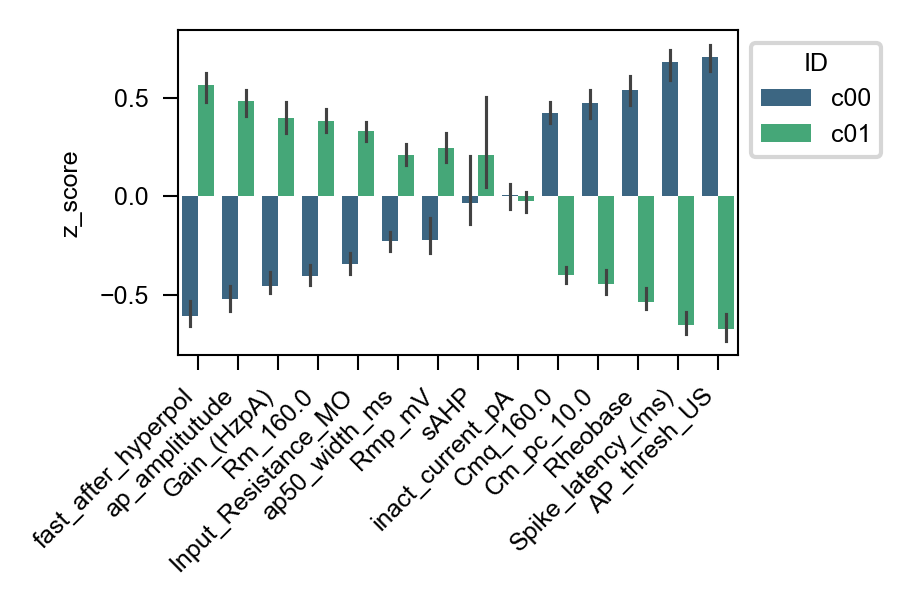

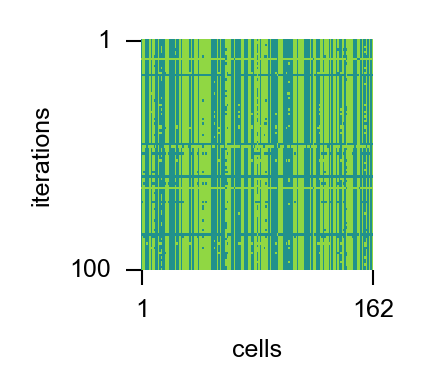

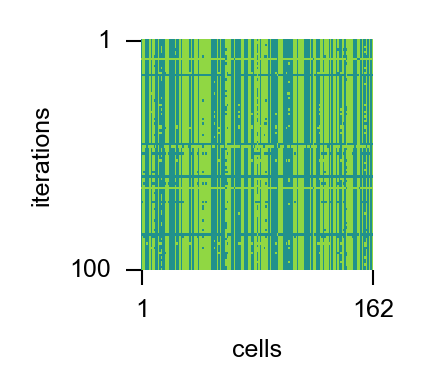

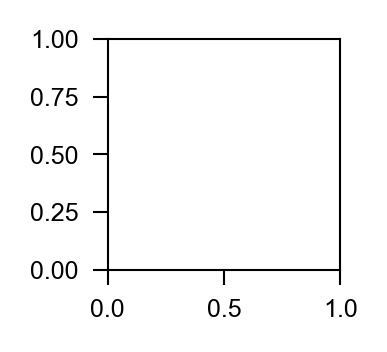

In [ ]:
"""
BootStrap Clustering
"""
import sklearn as skl

def fit_multi(data_for_fit,k,subsample=0.8,num_iter = 1000,ci=95):
    np.random.seed(42)
    subsample_bools = np.random.rand(data_for_fit.shape[0],num_iter)<subsample
    centroids = np.ones([k,data_for_fit.shape[1],num_iter])*np.nan
    labels = np.ones((data_for_fit.shape[0],num_iter))*np.nan
    distances = np.ones((data_for_fit.shape[0],k,num_iter))*np.nan

    for iter in tqdm( range(num_iter) ):
        subsample_data = data_for_fit[subsample_bools[:,iter]]
        kmeans_iter = skl.cluster.KMeans(n_clusters=k, random_state=42,n_init=1).fit(subsample_data)
        centers_iter = kmeans_iter.cluster_centers_.T
        labels_iter = kmeans_iter.predict(data_for_fit)
        distances_iter = kmeans_iter.transform(data_for_fit)

        if iter>0:
            corco = np.corrcoef(centers_iter.T,centroids[:,:,0])
            corco = corco[0:k,k:]
            ind = np.argmax(corco,axis=0)
            centers_iter = centers_iter[:,ind]
            labels_iter = [ind[l] for l in labels_iter]
            distances_iter = distances_iter[:, ind]

        centroids[:,:,iter] = centers_iter.T
        labels[:,iter] = labels_iter
        distances[:,:,iter] = distances_iter

    return centroids, labels, distances

def plot_k_results(centroids, cell_labels,feature_list):

    p_order = np.argsort(np.mean(centroids,axis=-1)[0])
    p_order = p_order.astype(int)
    feature_list = [feature_list[i] for i in p_order]
    centroids = centroids[:,p_order,:]

    num_groups, num_features, num_observations = centroids.shape
    index = pd.MultiIndex.from_product([range(num_groups), range(num_features)], names=['cluster', 'feature'])
    df = pd.DataFrame(centroids.reshape(-1, num_observations), index=index).reset_index()
    df_long = df.melt(id_vars=['cluster', 'feature'], var_name='iter', value_name='z_score')
    df_long['cluster'] = df_long['cluster'].astype(str).str.zfill(2).radd('c')

    # Step 3: Plot using sns.barplot
    fig_loadings = plt.figure(figsize=(3, 2))
    ax=sns.barplot(data=df_long, x='feature', y='z_score', hue='cluster', errorbar=('ci', 99.999),palette='viridis')
    # ax = sns.violinplot(data=df_long, x='feature', y='z_score', hue='cluster', palette='viridis', inner=None)
    # sns.swarmplot(data=df_long, x='feature', y='z_score', hue='cluster', palette='viridis', dodge=True, size=.3, ax=ax)
    ax.set_xticks(np.arange(len(feature_list)),feature_list,rotation=45,ha='right')
    ax.legend(title='ID',loc='upper left', bbox_to_anchor=(1, 1))
    ax.set_xlabel(None)
    plt.tight_layout()
    plt.show()

    fig_labels,ax = plt.subplots(figsize=(1, 1))
    ax=sns.heatmap(cell_labels.T, cmap='viridis',vmin=-1.5,vmax=1.5, cbar=False)
    ax.set_xticks([1,cell_labels.shape[0]],[1,cell_labels.shape[0]],rotation=0)
    ax.set_yticks([1,cell_labels.shape[1]],[1,cell_labels.shape[1]])
    ax.set_xlabel('cells')
    ax.set_ylabel('iterations')

    fig_labels,ax = plt.subplots(figsize=(1, 1))
    ax=sns.heatmap(cell_labels.T, cmap='viridis',vmin=-1.5,vmax=1.5, cbar=False)
    ax.set_xticks([1,cell_labels.shape[0]],[1,cell_labels.shape[0]],rotation=0)
    ax.set_yticks([1,cell_labels.shape[1]],[1,cell_labels.shape[1]])
    ax.set_xlabel('cells')
    ax.set_ylabel('iterations')


    return fig_loadings, fig_labels

def get_data_z(data_df,feature_list,file_str,strat_cols= ['Strat_ID','Genotype','Age_Bin']):
    abrg_cols = feature_list + ['Strat_ID','Genotype','Age_Bin']
    abrg_df = data_df[abrg_cols]
    abrg_df = abrg_df.dropna()
    abrg_df.to_csv(f'{file_str}.csv')

    data_x = np.array(abrg_df[feature_list].values).astype(float)
    data_z = (data_x - np.mean(data_x,0)) / np.std(data_x,0)
    return data_z

# display(concat_t1_df)
# display(concat_t2_df)

data_z_t1 = get_data_z(concat_t1_df,feature_list,file_str='type_1')
centroids_t1, cell_labels_t1, distances_t1 = fit_multi(data_z_t1, k=2, subsample=0.5, num_iter=100)
plot_k_results(centroids_t1, cell_labels_t1,feature_list)


fig_dist,ax = plt.subplots(figsize=(1, 1))
md = np.mean(distances_t1,axis=2)

# data_z_t2 = get_data_z(concat_t2_df,feature_list,file_str='type_2')
# centroids_t2, cell_labels_t2, distances_t2 = fit_multi(data_z_t2, k=2, subsample=0.5, num_iter=1000)
# plot_k_results(centroids_t2, cell_labels_t2,feature_list)

# data_z_c = get_data_z(concat_df,feature_list,file_str='comb')
# centroids_c, cell_labels_c, distances_c = fit_multi(data_z_c, k=2, subsample=0.5, num_iter=1000)
# plot_k_results(centroids_c, cell_labels_c,feature_list)

In [ ]:
# stats_df = t1_posthoc_tables['Rheobase']
# sig_df = stats_df[stats_df['p-adj']<=0.05]



# in_pairs =[]
# for (p1,p2) in pairs:
#     for i,(g1,g2) in enumerate(zip(sig_df['group1'],sig_df['group2'])):
#         groups = [g1,g2]
#         if p1 in groups and p2 in groups:
#             in_pairs.append(i)
# sig_df = sig_df.iloc[in_pairs,:]
# display(sig_df)

# def add_stats(fig,stats_df,label_dict=None):


#     bar_list = []
#     ax = fig.axes[0]
#     current_labels = [tick.get_text() for tick in ax.get_xticklabels()]
#     if label_dict is None:
#         label_dict={cl:cl for cl in current_labels}
#     for _,comp in stats_df.iterrows():
#         g1 = label_dict[comp['group1']]
#         g2 = label_dict[comp['group2']]
#         x1 = current_labels.index(g1)
#         x2 = current_labels.index(g2)
#         p = comp['p-adj']
#         bar_list.append((x1,x2,p))

#     ylims = ax.get_ylim()
#     current_top = np.max(ylims)
#     h_step = (ylims[1] - ylims[0])*.05
#     for bar in bar_list:
#         delta_bar = bar[1] - bar[0]
#         b_height = current_top + h_step*(delta_bar)


#         print(b_height)

#         ax.plot([bar[0]+.1,bar[1]-.1],[b_height]*2,'k',linewidth=.5)
#         ax.text((bar[0]+bar[1])/2, b_height-h_step/2, p_to_astk(bar[2]),ha='center',va='bottom' )
#     plt.draw()
#     return bar_list






In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

def single_violin_plot(data_subset, metric, color_map, label_columns, title=None):
    """
    Helper function to create a single violin plot.

    Parameters:
    - data_subset: DataFrame with ['Strat_ID', metric] and label columns.
    - metric: The name of the metric/column to plot.
    - label_dict: Dictionary for renaming 'Strat_ID' labels.
    - color_map: Dictionary mapping 'Strat_ID' to colors.
    - order: List of 'Strat_ID' values to enforce order.
    - title: Title for the plot (optional).
    - stats_df: DataFrame containing statistics for annotations (optional).
    """
    fig, ax = plt.subplots(1, 1, figsize=(2, 1))
    order = list(color_map.keys())

    # Create the violin plot
    sns.violinplot(x='Strat_ID', y=metric, data=data_subset, width=0.7, ax=ax,
                   hue='Strat_ID', palette=color_map, order=order,
                   inner="quartile", linewidth=.2)

    # Customize violin colors
    # print(color_map)
    violins = [v for v in ax.collections if isinstance(v, matplotlib.collections.PolyCollection)]
    for i, violin in enumerate(violins):
        violin.set_facecolor([0.9, 0.9, 0.9])  # Set the fill color to light gray
        violin.set_edgecolor(color_map[order[i % len(order)]])  # Set edge color using colors
        violin.set_linewidth(1)  # Set the linewidth to make the edges more visible

    # Create the scatter plot on the same axes
    sns.stripplot(x='Strat_ID', y=metric, data=data_subset, ax=ax,
                  color='black', order=order, size=1, jitter=True)
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
    ax.set_xlabel(None)



    # Set the title if provided
    if title is not None:
        ax.set_title(title)

    # # Add statistical significance annotations if stats_df is provided
    posthoc_df = do_stats(data_subset,label_columns,metric)
    display(posthoc_df)
    bar_list = get_stat_bar_info(data_subset,posthoc_df,ax.get_xticklabels())
    for bar in bar_list:
        ax.plot( [bar['x1'],bar['x2']], [bar['h']]*2,'k',linewidth=.5 )
        ax.text( np.mean([bar['x1'],bar['x2']]), bar['h'],bar['sig'],ha='center' )
    plt.show()

    return fig

# Update plot_violins function to add label columns to data_subset
def plot_violins(data_df, plot_list,  label_columns, ordered_colors, title=None, stats_dict=None):
    """
    Main function to generate violin plots for a list of metrics.

    Parameters:
    - data_df: DataFrame containing the data.
    - plot_list: List of metrics/columns to plot.
    - label_dict: Dictionary to map 'Strat_ID' values to more readable labels.
    - label_columns: List of columns to use for creating 'Strat_ID'.
    - colors: List of colors for the violin plots.
    - title: Title for the plots (optional).
    - stats_dict: Dictionary containing statistical information for annotations (optional).
    """
    # Dynamically create 'Strat_ID' by concatenating values from label_columns
    data_df['Strat_ID'] = data_df[label_columns].astype(str).agg(' '.join, axis=1)

    # # my_order = list(label_dict.keys())
    # if colors is None:

    # color_map = dict(zip(my_order, sns.color_palette(colors)))

    fig_dict = {}
    for metric in plot_list:
        # Subset the data to include 'Strat_ID', metric, and label columns
        data_subset = data_df[['Strat_ID', metric] + label_columns].copy()
        data_subset = data_subset.dropna()
        data_subset.to_csv('data_subset.csv')
        fig = single_violin_plot(data_subset, metric,  ordered_colors, label_columns, title)
        fig_dict[metric] = fig

    return fig_dict


def do_stats(data_df,label_columns,metric):
    data_subset = data_df[['Strat_ID', metric] + label_columns].copy()
    data_subset = data_subset.dropna()
    data_subset[metric] = pd.to_numeric(data_subset[metric], errors='coerce')
    data_subset.to_csv('data_subset.csv')

    posthoc = pairwise_tukeyhsd(data_subset[metric], data_subset[label_columns[0]].astype(str) + ' ' + data_subset[label_columns[1]].astype(str),
                                        alpha=0.05)
    posthoc_df = pd.DataFrame(data=posthoc.summary().data[1:], columns=posthoc.summary().data[0])
    posthoc_df = posthoc_df.sort_values(by='p-adj', ascending=True)

    pairs = [('Young E3KI','Young E4KI'),
            ('Young E4KI','Young EKO'),
            ('Aged E3KI','Aged E4KI'),
            ('Aged E4KI','Aged EKO'),]

    in_pairs =[]
    for (p1,p2) in pairs:
        for i,(g1,g2) in enumerate(zip(posthoc_df['group1'],posthoc_df['group2'])):
            groups = [g1,g2]
            if p1 in groups and p2 in groups:
                in_pairs.append(i)

    posthoc_df = posthoc_df.iloc[in_pairs,:]
    posthoc_df = posthoc_df[posthoc_df['p-adj']<=0.05]

    return posthoc_df


def p_to_astk(p_val):
        astk_range = [0.05,0.01,0.001,0.0001]
        num_astk = ["*" for t in astk_range if p_val <= t ]
        return "".join(num_astk)

def get_stat_bar_info(data_subset, posthoc_df, xticklabels):
    # display(data_subset)
    # display(posthoc_df)
    label_texts = [label.get_text() for label in xticklabels]
    bar_list =[]
    h0 = np.max(data_subset[data_subset.columns[1]])
    h_null = np.min(data_subset[data_subset.columns[1]])
    for _,comp in posthoc_df.iterrows():
        g1 = comp['group1']
        g2 = comp['group2']
        # print(g1,g2)
        x1 = label_texts.index(g1)
        x2 = label_texts.index(g2)
        p_val = comp['p-adj']

        delta_x = np.abs(x2-x1)
        if delta_x <0:
            delta_x = -delta_x
            temp = x1
            x1=x2
            x2=x1

        hx = h0 + (h0-h_null)*0.1*delta_x
        bar_dict={'x1':x1+.05,
                 'x2':x2-.05,
                 'h':hx,
                 'sig':p_to_astk(p_val)}

        bar_list.append(bar_dict)
    return bar_list


def p_to_astk(p_val):
    astk_range = [0.05,0.01,0.001,0.0001]
    num_astk = ["*" for t in astk_range if p_val <= t ]
    return "".join(num_astk)


ordered_colors = {'Young E3KI':(0.0, 0.0, 1.0),
                  'Young E4KI':(1.0, 0.0, 0.0),
                  'Young EKO':(1.0, 0.5, 0.0),
                  'Aged E3KI':(0.0, 0.0, 1.0),
                  'Aged E4KI':(1.0, 0.0, 0.0),
                  'Aged EKO':(1.0, 0.5, 0.0),}

type_1_fig_dict = plot_violins(concat_t1_df, feature_list,  ['Age_Bin', 'Genotype'],ordered_colors,title='Type I')
type_2_fig_dict = plot_violins(concat_t2_df, feature_list,  ['Age_Bin', 'Genotype'],ordered_colors,title='Type II')
combined_fig_dict = plot_violins(concat_df, feature_list,  ['Age_Bin', 'Genotype'],ordered_colors,title='Combined')


In [ ]:
os.path.join(dir,k)

'figs_combined\\Cm_pc_10.0'

In [ ]:

dir = 'figs_combined'
os.makedirs(dir,exist_ok=True)
for k,v in combined_fig_dict.items():
    v.savefig( os.path.join(dir,k).replace('.','_'))

dir = 'figs_type_2'
os.makedirs(dir,exist_ok=True)
for k,v in type_2_fig_dict.items():
    v.savefig( os.path.join(dir,k).replace('.','_'))

dir = 'figs_type_1'
os.makedirs(dir,exist_ok=True)
for k,v in type_1_fig_dict.items():
    v.savefig( os.path.join(dir,k).replace('.','_'))


In [ ]:
concat_df.to_csv('check_nan.csv')

In [ ]:
os.getcwd()

'C:\\Users\\dennis.tabuena\\Dropbox (Gladstone)\\0_Projects\\_ApoE Patch Seq\\Analysis_Workspace\\Ephys\\patch_seq_Cohort_02'

In [ ]:



# data_df = concat_t1_df
# label_columns=['Age_Bin', 'Genotype']
# metric='Rheobase'
# data_subset = data_df[['Strat_ID', metric] + label_columns].copy()
# data_subset = data_subset.dropna()
# data_subset.to_csv('data_subset.csv')



# posthoc_df =  do_stats(data_subset,label_columns)
# display(posthoc_df)

In [ ]:
import sklearn as skl
import pandas as pd
import statsmodels as sm

def encode_categorical_features(df, key_list, interactions_list):
    # Copy only the necessary columns (from key_list) to a new dataframe
    x_full = df[key_list].copy()

    # Create interaction columns by concatenating the values from the relevant columns
    for col1, col2 in interactions_list:
        interaction_name = f"{col1}_x_{col2}"
        x_full[interaction_name] = df[col1].astype(str) + "_" + df[col2].astype(str)

    # Encode the categorical columns (key_list + interaction columns)
    encoder = skl.preprocessing.OrdinalEncoder()
    categorical_cols = key_list + [f"{col1}_x_{col2}" for col1, col2 in interactions_list]
    x_full[categorical_cols] = encoder.fit_transform(x_full[categorical_cols])

    return x_full

def MLR_FDR_with_interactions(full_df, feature_cols, key_list, interactions_list):



    # First, encode categorical columns and interaction terms
    x_full = encode_categorical_features(full_df, key_list, interactions_list)

    results = {}
    # Loop over the feature columns to fit separate models
    for feature in feature_cols:

        y_full = full_df[feature].astype(float)  # Get the current target variable (dependent variable)
        # Add constant (intercept) to the feature matrix
        x_full_with_constant = sm.api.add_constant(x_full)

        # Fit OLS model for the current target variable
        full_model = sm.api.OLS(y_full, x_full_with_constant, missing='drop').fit()

        # Store the results
        results[feature] = full_model.summary()

    return results




In [ ]:
import statsmodels as sm
import scipy as sci

def encode_categorical_features(df, key_list, interactions_list):
    # Copy only the necessary columns (from key_list) to a new dataframe
    x_full = df[key_list].copy()

    # Create interaction columns by concatenating the values from the relevant columns
    for col1, col2 in interactions_list:
        interaction_name = f"{col1}_x_{col2}"
        x_full[interaction_name] = df[col1].astype(str) + "_" + df[col2].astype(str)

    # Encode the categorical columns (key_list + interaction columns) using one-hot encoding
    categorical_cols = key_list + [f"{col1}_x_{col2}" for col1, col2 in interactions_list]

    # Create dummy variables for the categorical columns (including interactions)
    x_full = pd.get_dummies(x_full, columns=categorical_cols, drop_first=True)
    x_full = x_full.astype(float)
    return x_full


def MLR_FDR_with_interactions(full_df, feature_cols, key_list, interactions_list=[]):
    columns_to_keep = key_list + feature_cols
    full_df = full_df[columns_to_keep]
    full_df = full_df.dropna()

    # Initialize a DataFrame to store results
    MLRT_df = pd.DataFrame(index=feature_cols, columns=[
        'Full Model log-likelihood',
        'Null Model log-likelihood',
        'LR statistic',
        'p value',
        'FDR corrected p',
        'Hit',
        'full_model',
        'null_model'
    ])

    # First, encode categorical columns and interaction terms
    x_full = encode_categorical_features(full_df, key_list, interactions_list)

    for feature in feature_cols:
        # Prepare the target variable (y) for the current feature
        y_full = full_df[feature].astype(float)

        # Add constant (intercept) to the feature matrix
        x_full_with_const = sm.api.add_constant(x_full)
        x_null = x_full_with_const[['const']]  # Null model uses only the intercept


        # Fit the full and null models
        full_model = sm.api.OLS(y_full, x_full_with_const, missing='drop').fit()
        null_model = sm.api.OLS(y_full, x_null, missing='drop').fit()

        # Calculate log-likelihoods, LR statistic, and p-value
        full_ll = full_model.llf
        null_ll = null_model.llf
        LR_statistic = -2 * (null_ll - full_ll)
        p_val = sci.stats.chi2.sf(LR_statistic, df=x_full_with_const.shape[1] - 1)

        # Store results in the DataFrame
        MLRT_df.at[feature, 'Full Model log-likelihood'] = full_ll
        MLRT_df.at[feature, 'Null Model log-likelihood'] = null_ll
        MLRT_df.at[feature, 'LR statistic'] = LR_statistic
        MLRT_df.at[feature, 'p value'] = p_val
        MLRT_df.at[feature, 'full_model'] = full_model
        MLRT_df.at[feature, 'null_model'] = null_model


    # Apply FDR correction to p-values
    FDR = sm.stats.multitest.fdrcorrection(MLRT_df['p value'].astype(float), alpha=0.05)
    MLRT_df['FDR corrected p'] = FDR[1]
    MLRT_df['Hit'] = FDR[0]

    MLRT_df = MLRT_df.sort_values(by='FDR corrected p', ascending=True)

    return MLRT_df, x_full



In [ ]:
MLRT_df, x_full = MLR_FDR_with_interactions(concat_t1_df,feature_list,key_list = ['Genotype', 'Age_Bin'] ) #    , interactions_list=[('Genotype', 'Age_Bin')]
display(MLRT_df)
MLRT_df.to_csv('MLRT_t1.csv')
MLRT_df, x_full = MLR_FDR_with_interactions(concat_t2_df,feature_list,key_list = ['Genotype', 'Age_Bin'] ) #    , interactions_list=[('Genotype', 'Age_Bin')]
display(MLRT_df)
MLRT_df.to_csv('MLRT_t2.csv')
MLRT_df, x_full = MLR_FDR_with_interactions(concat_df,feature_list,key_list = ['Genotype', 'Age_Bin'] ) #    , interactions_list=[('Genotype', 'Age_Bin')]
display(MLRT_df)
MLRT_df.to_csv('MLRT_comb.csv')

,Full Model log-likelihood,Null Model log-likelihood,LR statistic,p value,FDR corrected p,Hit,full_model,null_model
ap50_width_ms,3.355789,-35.812327,78.336231,0.0,9.772249e-16,True,<statsmodels.regression.linear_model.Regressio...,<statsmodels.regression.linear_model.Regressio...
Rheobase,-680.137471,-688.255743,16.236545,0.001014,7.098888e-03,True,<statsmodels.regression.linear_model.Regressio...,<statsmodels.regression.linear_model.Regressio...
Cm_pc_10.0,-646.990179,-654.39811,14.815862,0.001981,9.244500e-03,True,<statsmodels.regression.linear_model.Regressio...,<statsmodels.regression.linear_model.Regressio...
Cmq_160.0,-658.67292,-664.774992,12.204145,0.006716,2.350453e-02,True,<statsmodels.regression.linear_model.Regressio...,<statsmodels.regression.linear_model.Regressio...
Input_Resistance_MO,-1056.676363,-1061.951796,10.550867,0.01442,3.269349e-02,True,<statsmodels.regression.linear_model.Regressio...,<statsmodels.regression.linear_model.Regressio...
Rm_160.0,-1103.097734,-1108.316956,10.438444,0.015184,3.269349e-02,True,<statsmodels.regression.linear_model.Regressio...,<statsmodels.regression.linear_model.Regressio...
Gain_(HzpA),-48.264726,-53.40361,10.277768,0.016347,3.269349e-02,True,<statsmodels.regression.linear_model.Regressio...,<statsmodels.regression.linear_model.Regressio...
Rmp_mV,-610.182023,-614.003083,7.64212,0.054017,9.452984e-02,False,<statsmodels.regression.linear_model.Regressio...,<statsmodels.regression.linear_model.Regressio...
AP_thresh_US,-621.78187,-624.556099,5.548457,0.135769,2.111961e-01,False,<statsmodels.regression.linear_model.Regressio...,<statsmodels.regression.linear_model.Regressio...
fast_after_hyperpol,-564.405612,-566.559432,4.307641,0.230104,3.221450e-01,False,<statsmodels.regression.linear_model.Regressio...,<statsmodels.regression.linear_model.Regressio...


,Full Model log-likelihood,Null Model log-likelihood,LR statistic,p value,FDR corrected p,Hit,full_model,null_model
ap50_width_ms,-11.058882,-25.235954,28.354144,0.000003,0.000043,True,<statsmodels.regression.linear_model.Regressio...,<statsmodels.regression.linear_model.Regressio...
Spike_latency_(ms),-368.085442,-375.522455,14.874025,0.001928,0.008924,True,<statsmodels.regression.linear_model.Regressio...,<statsmodels.regression.linear_model.Regressio...
Rheobase,-340.729853,-348.082664,14.705622,0.002086,0.008924,True,<statsmodels.regression.linear_model.Regressio...,<statsmodels.regression.linear_model.Regressio...
AP_thresh_US,-242.918294,-250.057514,14.27844,0.00255,0.008924,True,<statsmodels.regression.linear_model.Regressio...,<statsmodels.regression.linear_model.Regressio...
Gain_(HzpA),14.472752,8.809971,11.325564,0.01009,0.028251,True,<statsmodels.regression.linear_model.Regressio...,<statsmodels.regression.linear_model.Regressio...
Input_Resistance_MO,-445.349749,-448.694552,6.689606,0.082477,0.173105,False,<statsmodels.regression.linear_model.Regressio...,<statsmodels.regression.linear_model.Regressio...
ap_amplitutude,-270.37119,-273.66129,6.580199,0.086553,0.173105,False,<statsmodels.regression.linear_model.Regressio...,<statsmodels.regression.linear_model.Regressio...
Rm_160.0,-467.740848,-469.283249,3.0848,0.378735,0.662785,False,<statsmodels.regression.linear_model.Regressio...,<statsmodels.regression.linear_model.Regressio...
inact_current_pA,-254.511058,-255.864526,2.706935,0.43905,0.682967,False,<statsmodels.regression.linear_model.Regressio...,<statsmodels.regression.linear_model.Regressio...
Rmp_mV,-267.898381,-269.083778,2.370793,0.499095,0.698733,False,<statsmodels.regression.linear_model.Regressio...,<statsmodels.regression.linear_model.Regressio...


,Full Model log-likelihood,Null Model log-likelihood,LR statistic,p value,FDR corrected p,Hit,full_model,null_model
ap50_width_ms,-11.667313,-62.434536,101.534448,0.0,1.017807e-20,True,<statsmodels.regression.linear_model.Regressio...,<statsmodels.regression.linear_model.Regressio...
Rheobase,-1071.763272,-1087.773275,32.020005,0.000001,3.628034e-06,True,<statsmodels.regression.linear_model.Regressio...,<statsmodels.regression.linear_model.Regressio...
Input_Resistance_MO,-1519.985031,-1529.951969,19.933876,0.000175,8.175225e-04,True,<statsmodels.regression.linear_model.Regressio...,<statsmodels.regression.linear_model.Regressio...
Gain_(HzpA),-46.032324,-55.312302,18.559956,0.000337,9.438252e-04,True,<statsmodels.regression.linear_model.Regressio...,<statsmodels.regression.linear_model.Regressio...
Spike_latency_(ms),-1167.753738,-1177.179469,18.851463,0.000293,9.438252e-04,True,<statsmodels.regression.linear_model.Regressio...,<statsmodels.regression.linear_model.Regressio...
Rm_160.0,-1582.30026,-1589.951142,15.301765,0.001576,3.677596e-03,True,<statsmodels.regression.linear_model.Regressio...,<statsmodels.regression.linear_model.Regressio...
Cm_pc_10.0,-971.954124,-978.39772,12.887193,0.004887,9.774035e-03,True,<statsmodels.regression.linear_model.Regressio...,<statsmodels.regression.linear_model.Regressio...
Cmq_160.0,-968.585607,-973.90647,10.641725,0.01383,2.418133e-02,True,<statsmodels.regression.linear_model.Regressio...,<statsmodels.regression.linear_model.Regressio...
AP_thresh_US,-874.670849,-879.864505,10.387312,0.015545,2.418133e-02,True,<statsmodels.regression.linear_model.Regressio...,<statsmodels.regression.linear_model.Regressio...
ap_amplitutude,-951.966375,-954.525247,5.117744,0.163376,2.287259e-01,False,<statsmodels.regression.linear_model.Regressio...,<statsmodels.regression.linear_model.Regressio...


In [ ]:
concat_df['ap50_width_ms']
_ = [print(d) for d in concat_df['ap50_width_ms']]

In [ ]:
contingency_table = pd.crosstab(concat_df['Age_Bin'], concat_df['Genotype'])
display(contingency_table)
contingency_table.to_csv('counts_combined_df.csv')

print('Inactivating')
contingency_table_inac = pd.crosstab(concat_t1_df['Age_Bin'], concat_t1_df['Genotype'])
display(contingency_table_inac)
contingency_table_inac.to_csv('counts_concat_t1_df.csv')

print('Non Inactivating')
contingency_table_noninac = pd.crosstab(concat_t2_df['Age_Bin'], concat_t2_df['Genotype'])
display(contingency_table_noninac)
contingency_table_noninac.to_csv('counts_concat_t2_df.csv')




Genotype,E3KI,E4KI,EKO
Age_Bin,,,
Aged,36,41,47
Young,47,43,34


Inactivating


Genotype,E3KI,E4KI,EKO
Age_Bin,,,
Aged,27,34,31
Young,26,32,22


Non Inactivating


Genotype,E3KI,E4KI,EKO
Age_Bin,,,
Aged,9,7,16
Young,21,11,12


In [ ]:
CMH_data = np.stack( [contingency_table_noninac.values,contingency_table_inac.values],axis=-1)
CMH_data = np.transpose(CMH_data, (1, 0, 2))
CMH_data.shape
import statsmodels as sm


In [ ]:



cmh_data = np.array([
    [[9, 27], [21, 26]],   # E3KI
    [[7, 34], [11, 32]],   # E4KI
    # [[16, 31], [12, 22]]   # EKO
]).transpose(2, 1, 0)

# Perform Cochran-Mantel-Haenszel test
result = sm.api.stats.StratifiedTable(cmh_data).test_null_odds()

# Display results
print(f"CMH Statistic: {result.statistic}")
print(f"P-value: {result.pvalue}")

cmh_data = np.array([
    # [[9, 27], [21, 26]],   # E3KI
    [[7, 34], [11, 32]],   # E4KI
    [[16, 31], [12, 22]]   # EKO
]).transpose(2, 1, 0)

# Perform Cochran-Mantel-Haenszel test
result = sm.api.stats.StratifiedTable(cmh_data).test_null_odds()

# Display results
print(f"CMH Statistic: {result.statistic}")
print(f"P-value: {result.pvalue}")

CMH Statistic: 4.031088973987094
P-value: 0.04466909900172911
CMH Statistic: 0.5104283681773271
P-value: 0.47495347756192874


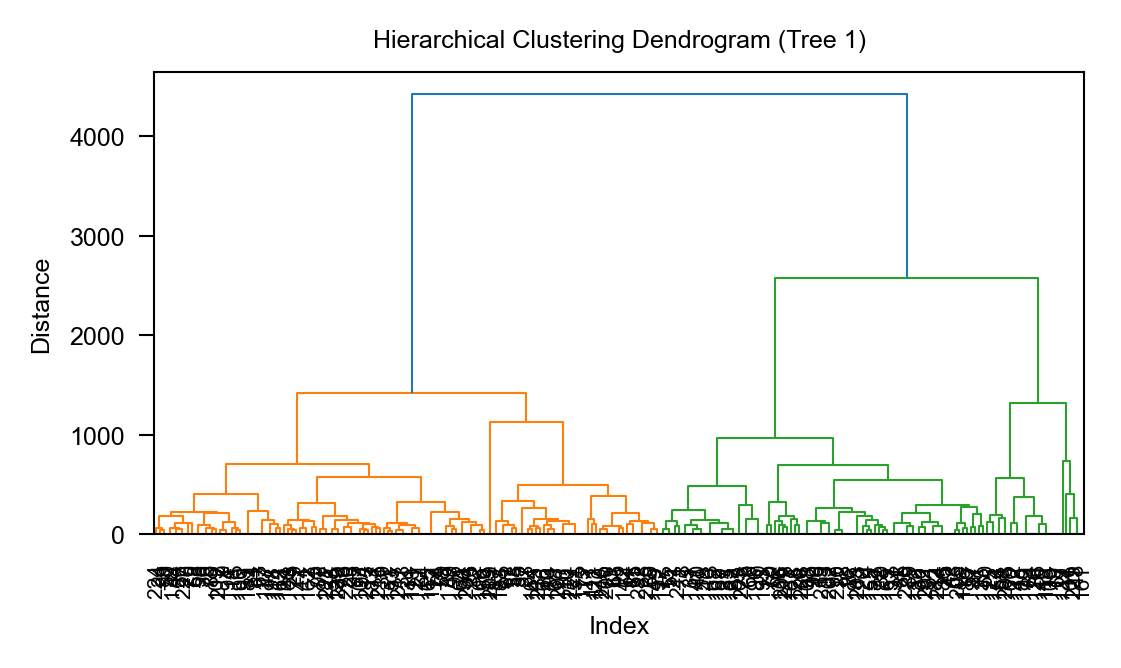

In [ ]:
import numpy as np
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

# Ensure all selected feature columns are numeric and handle missing values
X = concat_df[feature_list].apply(pd.to_numeric, errors='coerce')  # Convert non-numeric to NaN
X = X.dropna()  # Drop rows with NaN values (or alternatively, you can impute them)

# Convert the cleaned data to a numpy array
X = X.values

# Number of trees to generate
n_trees = 1

# Store linkage matrices for each random tree
random_trees = []

# Generate 100 random hierarchical trees
for _ in range(n_trees):
    # Randomly sample the data (with replacement)
    sample_indices = np.random.choice(X.shape[0], size=X.shape[0], replace=True)
    X_sample = X[sample_indices, :]

    # Compute the distance matrix for the sampled data
    distance_matrix = pdist(X_sample, metric='euclidean')

    # Perform hierarchical clustering and store the linkage matrix
    Z = linkage(distance_matrix, method='ward')
    random_trees.append(Z)

    # Plot the dendrogram for each random tree
    plt.figure(figsize=(4, 2))
    dendro = dendrogram(Z, no_plot=False)  # no_plot=True avoids showing the plot
    x_axis_order = dendro['leaves']
    plt.title(f"Hierarchical Clustering Dendrogram (Tree {_+1})")
    plt.xlabel("Index")
    plt.ylabel("Distance")
    plt.show()


232